Importing Modules

In [1]:
# import modules
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import os
import itertools

# Coppelia Remote Client
client = RemoteAPIClient()
#sim = client.getObject('sim')

Importing Classes

In [2]:
class Pattern:
    def __init__(self, pattern_size, square_size, type):
        self.pattern_size = pattern_size
        self.square_size = square_size
        self.type = type
        
        return
    
    def construct3DPoints(self):
        board_points = np.zeros((self.pattern_size[0] * self.pattern_size[1], 3), np.float32)
        board_points[:,:2] = np.mgrid[ 0:self.pattern_size[0], 0:self.pattern_size[1] ].T.reshape(-1,2)
        board_points = board_points * self.square_size
        
        return board_points
    
    def open_scene(self):
        scene_folder = "C:/Users/veloc/Documents/Calibration-Mocap/utils/virtual-calib/scenes/"
        scene_name = self.type + ".ttt"
        sim.loadScene(scene_folder + scene_name)

        return 

In [3]:
class CornerDetector:
    def __init__(self, image_path, pattern_size):
        self.image_path = image_path
        self.pattern_size = pattern_size
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        
        self.image_points = []
        self.image_size = 0
        return
    
    def detect_using_SB(self):
        # Create empty variables
        images_detected = 0
        
        # For each image in directory
        for image_file in self.image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, self.pattern_size, None)
            
            if detected:
                # Save corners in image points array
                self.image_points.append(corners)
                images_detected += 1
                
        return images_detected
    def detect_using_subpixel(self):
        # Create empty variables
        images_detected = 0
        
        # For each image in directory
        for image_file in self.image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCorners(gray, self.pattern_size, None)
            
            if detected:
                corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), self.criteria)
                # Save corners in image points array
                self.image_points.append(corners)
                images_detected += 1
                
            return images_detected            

In [6]:
class Calibrator: 
    def __init__(self, flags_calib, image_path, board_points, image_size, pattern_size):
        self.flags_calib = flags_calib
        self.image_path = image_path

        self.board_points = board_points
        self.image_points = []
        self.world_points = []

        self.image_size = image_size
        self.pattern_size = pattern_size

        self.results = {
        "error_rms": None,
        "camera_matrix": None,
        "distortion_coeffs": None,
        "rvecs": None,
        "tvecs": None,
        "std_intrinsic": None,
        "std_extrinsic": None,
        "per_view_error": None
        }
        return
    
    def prepare_world_points(self):
        
        for i in range(len(self.image_points)):
            self.world_points.append(self.board_points)
        return
    
    def detect_using_SB(self):
        # Create empty variables
        images_detected = 0
        self.image_points = []
        self.world_points = []
        
        # For each image in directory
        for image_file in self.image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, self.pattern_size, None)
            
            if detected:
                # Save corners in image points array
                self.image_points.append(corners)
                self.world_points.append(self.board_points)
                images_detected += 1
                
        return images_detected
    
    def calibrate(self):
        # Calibrate the camera
        rms, camera_matrix, distortion_coeffs, rvecs, tvecs, std_intrinsic, std_extrinsic, per_view_error = cv2.calibrateCameraExtended(self.world_points, self.image_points, self.image_size, None, None, flags=self.flags_calib)  

        
        # Save the calibration results
        self.results = {
        "error_rms": rms,
        "camera_matrix": camera_matrix,
        "distortion_coeffs": distortion_coeffs,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "std_intrinsic": std_intrinsic,
        "std_extrinsic": std_extrinsic,
        "per_view_error": per_view_error
        }

        #print("Result saved in 'Calibrator.results' ")
        
        return
    
    def calculate_error(self, type, image_path):
        # Create empty arrays for rotation and translation vectors
        rvecs = []
        tvecs = []
        errors = []
        
        # For each image in directory
        for image_file in image_path:
            # Read the image file
            img = cv2.imread(image_file)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Return the image size
            self.image_size = gray.shape[::-1]
            # Detect the corners in images
            detected, corners = cv2.findChessboardCornersSB(gray, self.pattern_size, None)

            # If it was detected
            if detected == True:
                # Calculate extrinsic parameters 
                _, rvec, tvec = cv2.solvePnP(self.board_points, corners, self.results['camera_matrix'], self.results['distortion_coeffs'])
                rvecs.append(rvec)
                tvecs.append(tvecs)

                # Calculate projected image points
                projected_image_points, _ = cv2.projectPoints(self.board_points, rvec, tvec, self.results['camera_matrix'], self.results['distortion_coeffs'])
                
                # Find the Euclidean Distance between projected and detected image points
                if type == 'mean':
                    error = cv2.norm(corners, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
                
                elif type == 'rms':
                    error = cv2.norm(corners, projected_image_points, normType= cv2.NORM_L2) / sqrt(len(projected_image_points))

                errors.append(error)
        return errors
    
    def per_view_error(self):
        image_files = []
        
        # Extract the image file name
        for image in self.image_path:
            nome_arquivo = os.path.basename(image)
            image_files.append(nome_arquivo)

        # Plot the images errors
        plt.figure(figsize=(10,7))
        plt.bar(image_files, self.results['per_view_error'].flatten(), color = 'royalblue', width=.75)

        plt.axhline(y=self.results['error_rms'], color='gray', linestyle='--', linewidth=1)
        
        plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
        plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
        plt.show()
        
            
    def train_test_split_images(self):
        
        # Step 1 - Initial Calibration
        self.calibrate()
        erros = self.calculate_error('rms', self.image_path)
        median = np.median(erros)
        std = np.std(erros)
        
        # Step 2 - Remove Outliers
        outliers = []
        limiar = median + std
        error = self.results['per_view_error'].flatten()
        
        # Check if the image error is gratter than limiar
        for idx, image in enumerate(self.image_path):
            
            if error[idx] > limiar:
                outliers.append(image)
                
        # Remove outliers from image path    
        for o in outliers:
            print('Remove outlier - ',os.path.basename(o))
            self.image_path.remove(o)

        # Train - Test split
        images_train, images_test, _, _ = train_test_split(self.image_path, np.zeros(len(self.image_path)), test_size = 0.3)
        
        return images_train, images_test

First Calibration - Checking the results

In [6]:
# Choose the image path
path = '../../../images/virtual/'
images = glob(path + '7x7/original/set_25/*.jpg')

# Create the calibration pattern
myPattern = Pattern(pattern_size = (7,7),
                    square_size = 30,
                    type = "chessboard_7x7")

# Create Calibrator object
myCalibrator = Calibrator(flags_calib = cv2.CALIB_RATIONAL_MODEL,
                          image_path = images,
                          board_points = myPattern.construct3DPoints(),
                          image_size = (720,720),
                          pattern_size = myPattern.pattern_size)

# Prepare the world points and image points for calibration
myCalibrator.detect_using_SB()

# Calibrate your camera
myCalibrator.calibrate()

# Show the results


Cross Validation

In [7]:
def cross_validation_camera(Pattern, Calibrator):
    errors_train = []
    errors_test = []
    camera_parameters = []
    
    # Split in train and test after outlier removal
    images_train, images_test = Calibrator.train_test_split_images()
    
    # Calibrating using Q'(train)
    Calibrator.image_path = images_train
    Calibrator.detect_using_SB()
    Calibrator.calibrate()
    error_train_q_linha = np.median(Calibrator.calculate_error('rms', images_train))
    
    # Testing in Q'(test)
    error_test_q_linha = np.median(Calibrator.calculate_error('rms', images_test))
    
    for i in range(5):
        # New split in Q'(train)
        new_train, new_test, _, _ = train_test_split(images_train, np.zeros(len(images_train)))

        # Update the image path
        Calibrator.image_path = new_train
        Calibrator.detect_using_SB()
        Calibrator.calibrate()
        
        # Calculate the erros in calibration
        error_train_cross = np.median(Calibrator.calculate_error('rms', new_train))
        error_test_cross = np.median(Calibrator.calculate_error('rms', new_test))
        
        errors_train.append(error_train_cross)
        errors_test.append(error_test_cross)
    
    # var_E_train = np.var(errors_train, ddof=1)
    # var_E_test = np.var(errors_test, ddof=1)
    
    E_kf = sqrt((np.var(errors_train, ddof=1) + np.var(errors_test, ddof=1)))
        
    return E_kf

In [ ]:
cross_validation_camera(myPattern, myCalibrator)

Statitics Analysis

- Perform calibration using differents sizes of $Q$
- Plot the curve of error for each size of $Q$
- Analysis between 2 and 50

In [ ]:
bit_generator = np.random.PCG64DXSM()

rng = np.random.Generator(bit_generator)

rng.choice([1,2,3,4,5,6,7,8,9], size=3, replace=False)

array([1, 3, 6])

In [8]:
def random_select_images(images, size_of_q):
    new_image_set = []
    
    # Using the PCG64DXSM Bit Generator
    bit_generator = np.random.PCG64DXSM()
    rng = np.random.Generator(bit_generator)

    
    # Select the calibration images subset of size q
    randoms = rng.choice(np.arange(0,len(images)),size_of_q, replace=False)
    
    for index in randoms:
        new_image_set.append(images[index])
    
    return new_image_set

def generate_images_subset(images, size_of_q):
    
    images_subsets = list(itertools.combinations(images,size_of_q))
    
    return images_subsets

In [9]:
all_images = glob('../../../images/virtual/7x7/opengl3/*.jpg')
E_kf = []


In [ ]:
all_images

In [ ]:
for i in range (45):
    print("Using", i+5, "images")
    image_set = random_select_images(all_images, i + 5)
    myCalibrator.image_path = image_set
    myCalibrator.detect_using_SB()
    e = cross_validation_camera(myPattern, myCalibrator)
    print(e)
    E_kf.append(e)
    

Text(0.5, 1.0, 'Variance in the Reprojection error for each size of Q')

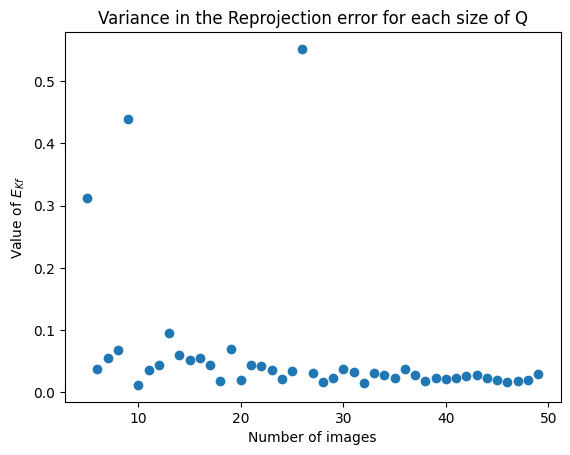

In [ ]:
plt.scatter(np.arange(5,50), E_kf)
plt.xlabel("Number of images")
plt.ylabel("Value of " + r'$E_{Kf}$')
plt.title("Variance in the Reprojection error for each size of " + r'Q')

In [ ]:
size_of_q = 40
fx_distribution = []

for i in range(100):
    print("Calibration n°", i+1)
    image_set = random_select_images(all_images, size_of_q)
    myCalibrator.image_path = image_set
    myCalibrator.detect_using_SB()
    
    new_train, _ = myCalibrator.train_test_split_images()
    myCalibrator.image_path = new_train
    myCalibrator.detect_using_SB()
    myCalibrator.calibrate()
    fx = myCalibrator.results['camera_matrix'][0][0]
    fx_distribution.append(fx)

Text(0.5, 1.0, 'Distribution of $f_x$ using $Q = 40$')

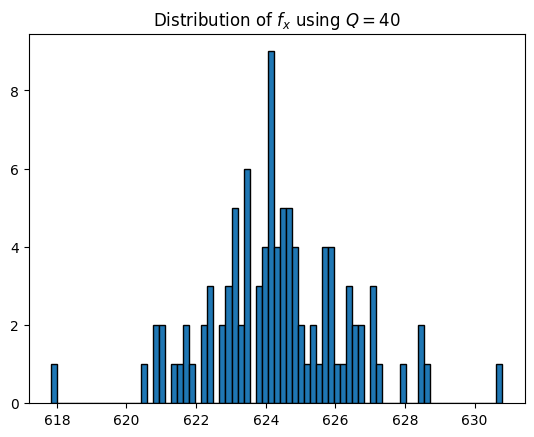

In [ ]:
plt.hist(fx_distribution, bins=75, edgecolor = 'black')
plt.title(r'Distribution of $f_x$ using $Q = 40$')

In [ ]:
np.var(fx_distribution)

3.8706069967004066

In [ ]:
len(list(itertools.combinations(all_images,25)))

In [ ]:
all_set_of_5 = generate_images_subset(all_images, size_of_q = 8)
new_sets = random_select_images(all_set_of_5, 200)


In [13]:

E_kf_combinations = []

for idx, image_set in enumerate(new_sets):
    print('Using set number ', idx)
    image_set = list(image_set)
    myCalibrator.image_path = image_set
    myCalibrator.detect_using_SB()
    e = cross_validation_camera(myPattern, myCalibrator)
    print(e)
    E_kf_combinations.append(e)

Using set number  0
Remove outlier -  image14.jpg
Remove outlier -  image2.jpg
1.7289895745166701
Using set number  1
Remove outlier -  image7.jpg
Remove outlier -  image8.jpg
1.4689172913329465
Using set number  2
0.15626175182287563
Using set number  3
Remove outlier -  image20.jpg
Remove outlier -  image4.jpg
0.02144822483205441
Using set number  4
Remove outlier -  image14.jpg
Remove outlier -  image2.jpg
0.5498464363063071
Using set number  5
Remove outlier -  image26.jpg
Remove outlier -  image28.jpg
5.32341529340062
Using set number  6
Remove outlier -  image2.jpg
Remove outlier -  image23.jpg
0.053148635993885966
Using set number  7
Remove outlier -  image6.jpg
Remove outlier -  image8.jpg
0.1830921715882304
Using set number  8
Remove outlier -  image20.jpg
Remove outlier -  image9.jpg
0.0884673740736837
Using set number  9
0.560056612323577
Using set number  10
0.43731574630128894
Using set number  11
0.3205189017855941
Using set number  12
Remove outlier -  image19.jpg
0.9139

In [14]:
np.median(E_kf_combinations)

0.3238313613894929